In [ ]:
from typing import Literal, TypedDict

from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from pydantic import BaseModel, Field

load_dotenv()

True

In [ ]:
class SelfExplanationState(TypedDict):
    problem: str
    problem_type: str
    initial_thoughts: str
    step_by_step_solution: list[dict[str, str]]
    self_explanation: str
    alternative_approaches: list[str]
    learning_points: list[str]
    final_answer: str
    explanation_quality: str

In [ ]:
llm = ChatOpenAI(model_name="mistralai/devstral-small")

In [ ]:
class ProblemAnalyzer(BaseModel):
    problem_type: str = Field(
        description="The type of problem to be solved, e.g., 'math', 'science', logic etc."
    )
    initial_thoughts: str = Field(
        description="Initial thoughts on the problem, including any assumptions or hypotheses."
    )

In [ ]:
def analyze_problem(state: SelfExplanationState):
    prompt = ChatPromptTemplate.from_template(
        """Problem: {problem}
    
    As an expert problem solver, analyze this problem:
    
    1. What type of problem is this? (math, logic, coding, etc.)
    2. What are your initial thoughts about how to approach it?
    3. What key concepts or principles are involved?
    """
    )

    structured_llm = llm.with_structured_output(ProblemAnalyzer)
    response = structured_llm.invoke(prompt.format(problem=state["problem"]))

    return {
        **state,
        "problem_type": response.problem_type,
        "initial_thoughts": response.initial_thoughts,
    }

In [ ]:
class StepSolving(BaseModel):
    step_x_action: list[str] = Field(
        description="What action the llm is doing at that particular moment"
    )
    step_x_why: list[str] = Field(description="Why are you doing the action")
    step_x_work: list[str] = Field(description="The actual work/calculation")
    step_x_result: list[str] = Field(description="What this solves")
    final_answer: str = Field(
        description="The final answer after the step by step reasoning"
    )

In [ ]:
def solve_step_by_step(state: SelfExplanationState):
    prompt = ChatPromptTemplate.from_template(
        """
        Problem: {problem}
        Problem Type: {problem_type}
        Initial Approach: {initial_thoughts}
    
        Now solve this problem step by step. For each step:
        1. State what you're doing
        2. Explain WHY you're doing it
        3. Show the calculation/logic
        4. Explain what this step achieves
        """
    )

    structured_llm = llm.with_structured_output(StepSolving)
    response = structured_llm.invoke(
        prompt.format_messages(
            problem=state["problem"],
            problem_type=state["problem_type"],
            initial_thoughts=state["initial_thoughts"],
        )
    )

    # Format the BaseModel output into the parseable string format
    formatted_output = []

    # Get the maximum number of steps
    max_steps = max(
        len(response.step_x_action),
        len(response.step_x_why),
        len(response.step_x_work),
        len(response.step_x_result),
    )

    # Format each step
    for i in range(max_steps):
        step_num = i + 1

        if i < len(response.step_x_action):
            formatted_output.append(
                f"STEP_{step_num}_ACTION: {response.step_x_action[i]}"
            )

        if i < len(response.step_x_why):
            formatted_output.append(f"STEP_{step_num}_WHY: {response.step_x_why[i]}")

        if i < len(response.step_x_work):
            formatted_output.append(f"STEP_{step_num}_WORK: {response.step_x_work[i]}")

        if i < len(response.step_x_result):
            formatted_output.append(
                f"STEP_{step_num}_RESULT: {response.step_x_result[i]}"
            )

    # Add final answer
    formatted_output.append(f"FINAL_ANSWER: {response.final_answer}")

    # Join all lines
    formatted_steps = "\n".join(formatted_output)

    return {
        **state,
        "step_by_step_solution": formatted_steps,
        "final_answer": response.final_answer,
    }

In [ ]:
def generate_self_explanation(state: SelfExplanationState) -> SelfExplanationState:
    """Generate a comprehensive self-explanation of the solution process"""

    steps_text = state["step_by_step_solution"]

    prompt = f"""
    Problem: {state['problem']}
    My Solution Steps:
    {steps_text}
    Final Answer: {state['final_answer']}
    
    Now I need to explain my reasoning process to help someone understand not just WHAT I did, but HOW I think about problems like this.
    
    Provide a comprehensive self-explanation that covers:
    1. My overall problem-solving strategy
    2. Why I chose this particular approach
    3. How each step builds on the previous ones
    4. What makes this solution reliable
    5. Common mistakes someone might make and how I avoided them
    
    Write this as if you're teaching someone your thought process.
    """

    response = llm.invoke([HumanMessage(content=prompt)])

    return {**state, "self_explanation": response.content}

In [ ]:
class Alternatives(BaseModel):
    alternatives: list[str] = Field(description="A list of alternatives to the problem")
    learning_points: list[str] = Field(
        description="A list of learning points that can be obtained from the model"
    )

In [ ]:
def identify_alternatives(state: SelfExplanationState):
    prompt = f"""
    Problem: {state['problem']}
    My Solution: {state['final_answer']}
    
    Now reflect on alternative approaches and learning opportunities:
    
    1. What are 2-3 alternative ways this problem could have been solved?
    2. What are the key learning points from this problem?
    3. What skills or concepts does this problem help develop?
    """

    structured_llm = llm.with_structured_output(Alternatives)
    response = structured_llm.invoke(prompt)

    return {
        **state,
        "alternative_approaches": response.alternatives,
        "learning_points": response.learning_points,
    }

In [ ]:
class Rating(BaseModel):
    explanation_quality: Literal["Excellent", "Good", "Needs Improvement"]

In [ ]:
def evaluate_explanation(state: SelfExplanationState):
    prompt = f"""Self-Explanation: {state['self_explanation']}
    
    Evaluate this self-explanation on:
    1. Clarity - Is it easy to follow?
    2. Completeness - Does it cover all important aspects?
    3. Educational value - Would it help someone learn?
    
    Rate as: Excellent, Good, or Needs Improvement
    """

    structured_llm = llm.with_structured_output(Rating)
    response = structured_llm.invoke(prompt)
    return {**state, "explanation_quality": response.explanation_quality}

In [ ]:
def create_self_explanation_graph():
    workflow = StateGraph(SelfExplanationState)

    # Add nodes
    workflow.add_node("analyze_problem", analyze_problem)
    workflow.add_node("solve_step_by_step", solve_step_by_step)
    workflow.add_node("generate_self_explanation", generate_self_explanation)
    workflow.add_node("identify_alternatives", identify_alternatives)
    workflow.add_node("evaluate_explanation", evaluate_explanation)

    # Add edges
    workflow.set_entry_point("analyze_problem")
    workflow.add_edge("analyze_problem", "solve_step_by_step")
    workflow.add_edge("solve_step_by_step", "generate_self_explanation")
    workflow.add_edge("generate_self_explanation", "identify_alternatives")
    workflow.add_edge("identify_alternatives", "evaluate_explanation")
    workflow.add_edge("evaluate_explanation", END)

    return workflow.compile()

In [ ]:
graph = create_self_explanation_graph()

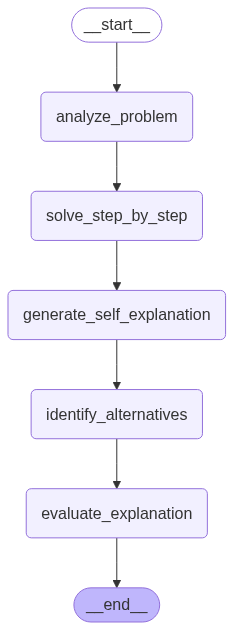

In [ ]:
graph

In [ ]:
def run_math_example():
    """Run with a math problem"""
    graph = create_self_explanation_graph()

    initial_state = SelfExplanationState(
        problem="Find the area of a triangle with vertices at (0,0), (4,0), and (2,3)",
        problem_type="",
        initial_thoughts="",
        step_by_step_solution=[],
        self_explanation="",
        alternative_approaches=[],
        learning_points=[],
        final_answer="",
        explanation_quality="",
    )

    result = graph.invoke(initial_state)
    print_results(result, "Geometry Problem")
    return result


def run_logic_example():
    """Run with a logic problem"""
    graph = create_self_explanation_graph()

    initial_state = SelfExplanationState(
        problem="If all roses are flowers, and some flowers are red, can we conclude that some roses are red?",
        problem_type="",
        initial_thoughts="",
        step_by_step_solution=[],
        self_explanation="",
        alternative_approaches=[],
        learning_points=[],
        final_answer="",
        explanation_quality="",
    )

    result = graph.invoke(initial_state)
    print_results(result, "Logic Problem")
    return result


def run_coding_example():
    """Run with a coding problem"""
    graph = create_self_explanation_graph()

    initial_state = SelfExplanationState(
        problem="Write a function to find the second largest number in a list of integers",
        problem_type="",
        initial_thoughts="",
        step_by_step_solution=[],
        self_explanation="",
        alternative_approaches=[],
        learning_points=[],
        final_answer="",
        explanation_quality="",
    )

    result = graph.invoke(initial_state)
    print_results(result, "Coding Problem")
    return result

In [ ]:
def print_results(result, problem_title):
    """Print the results in a formatted way"""
    print(f"\n=== {problem_title} - Self-Explanation Results ===")
    print(f"Problem: {result['problem']}")
    print(f"Problem Type: {result['problem_type']}")
    print(f"Initial Thoughts: {result['initial_thoughts']}")

    print("\n--- Step-by-Step Solution ---")

    print(result["step_by_step_solution"])

    print(f"\nFinal Answer: {result['final_answer']}")

    print("\n--- Self-Explanation ---")
    print(result["self_explanation"])

    print("\n--- Alternative Approaches ---")
    for i, alt in enumerate(result["alternative_approaches"], 1):
        print(f"{i}. {alt}")

    print("\n--- Learning Points ---")
    for i, point in enumerate(result["learning_points"], 1):
        print(f"{i}. {point}")

    print(f"\nExplanation Quality: {result['explanation_quality']}")

In [ ]:
# Run different examples
print("Choose an example to run:")
print("1. Math/Geometry Problem")
print("2. Logic Problem")
print("3. Coding Problem")

choice = input("Enter choice (1-3): ")

if choice == "1":
    run_math_example()
elif choice == "2":
    run_logic_example()
elif choice == "3":
    run_coding_example()
else:
    print("Running math example by default...")
    run_math_example()

Choose an example to run:
1. Math/Geometry Problem
2. Logic Problem
3. Coding Problem

=== Coding Problem - Self-Explanation Results ===
Problem: Write a function to find the second largest number in a list of integers
Problem Type: coding
Initial Thoughts: This problem involves finding the second largest number in a list of integers. To approach this, we can iterate through the list while keeping track of the largest and second largest numbers encountered so far. We need to handle edge cases such as lists with fewer than two elements. Key concepts include iteration, comparison, and maintaining state variables.

--- Step-by-Step Solution ---
STEP_1_ACTION: Define the function and initialize variables
STEP_1_WHY: To initialize variables that will keep track of the largest and second largest numbers.
STEP_1_WORK: def find_second_largest(numbers):
    if len(numbers) < 2:
        return None  # Handle edge case with fewer than two elements
    largest = second_largest = float('-inf')

STE

## Test the generated code

In [ ]:
def find_second_largest(numbers):
    if len(numbers) < 2:
        return None  # Handle edge case with fewer than two elements
    largest = second_largest = float("-inf")
    for number in numbers:
        if number > largest:
            second_largest = largest
            largest = number
        elif number > second_largest and number != largest:
            second_largest = number
    return second_largest

In [ ]:
find_second_largest([3, 1, 4, 4, 5, 2])

4